## Stockmarket analysis with `pmdarima`

This example follows the post on [Towards Data Science](https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a) (TDS), demonstrating the use of `pmdarima` to simplify time series analysis.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.3.0-dev0


### Import the data

`pmdarima` contains an embedded `datasets` submodule that allows us to try out models on common datasets. We can load the MSFT stock data from `pmdarima` 1.3.0+:

In [2]:
from pmdarima.datasets.stocks import load_msft

df = load_msft()
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


### Split the data

As in the blog post, we'll use 80% of the samples as training data. Note that a time series' train/test split is different from that of a dataset without temporality; order *must* be preserved if we hope to discover any notable trends.

In [3]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['Open'].values
y_test = test_data['Open'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

6386 train samples
1597 test samples


### Pre-modeling analysis

TDS fixed ``p`` at 5 based on some lag plot analysis:

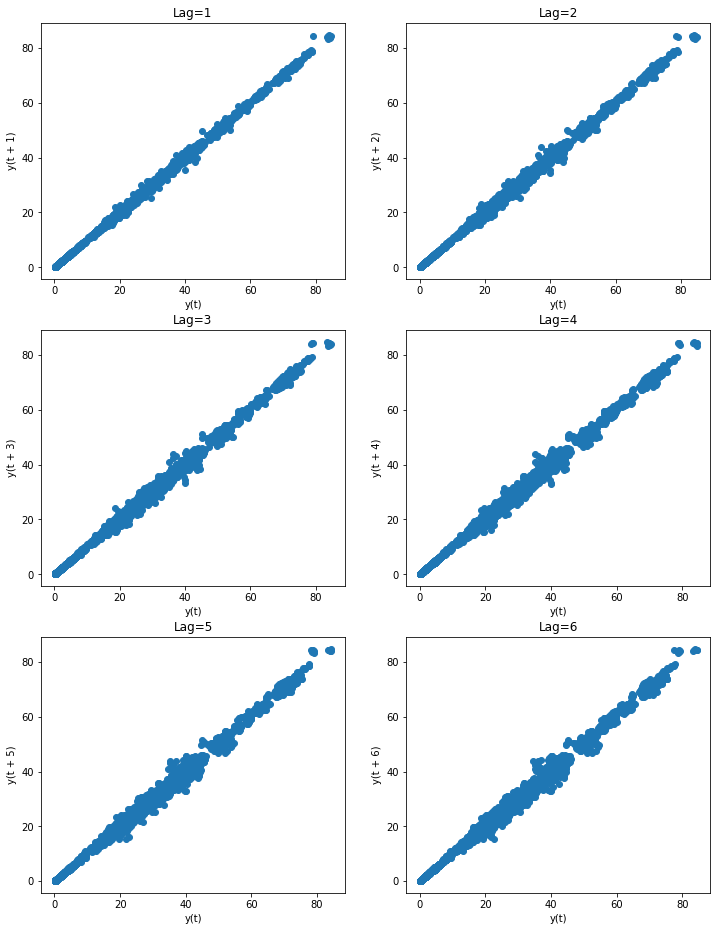

In [18]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['Open'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

All lags look fairly linear, so it's a good indicator that an auto-regressive model is a good choice. Therefore, we'll allow the `auto_arima` to select the lag term for us, up to 6.

### Estimating the differencing term

We can estimate the best lag term with several statistical tests:

In [19]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


Use `auto_arima` to fit a model on the data.

In [74]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=5640.878, BIC=5654.402, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5640.426, BIC=5660.711, Fit time=0.074 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5640.350, BIC=5660.635, Fit time=0.050 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5640.152, BIC=5667.198, Fit time=0.607 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1); AIC=5641.440, BIC=5675.249, Fit time=0.556 seconds
Total fit time: 2.311 seconds


In [75]:
print(auto.order)

(1, 1, 1)


In [76]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 0.3416473178248818
SMAPE: 0.981464018635346


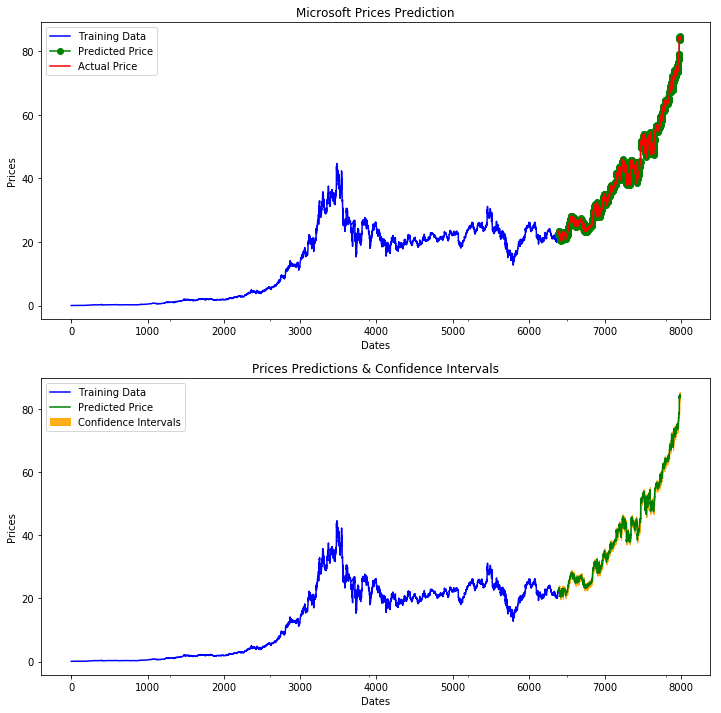

In [86]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Microsoft Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

In [88]:
df["Date"]

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
5       1986-03-20
6       1986-03-21
7       1986-03-24
8       1986-03-25
9       1986-03-26
10      1986-03-27
11      1986-03-31
12      1986-04-01
13      1986-04-02
14      1986-04-03
15      1986-04-04
16      1986-04-07
17      1986-04-08
18      1986-04-09
19      1986-04-10
20      1986-04-11
21      1986-04-14
22      1986-04-15
23      1986-04-16
24      1986-04-17
25      1986-04-18
26      1986-04-21
27      1986-04-22
28      1986-04-23
29      1986-04-24
           ...    
7953    2017-10-02
7954    2017-10-03
7955    2017-10-04
7956    2017-10-05
7957    2017-10-06
7958    2017-10-09
7959    2017-10-10
7960    2017-10-11
7961    2017-10-12
7962    2017-10-13
7963    2017-10-16
7964    2017-10-17
7965    2017-10-18
7966    2017-10-19
7967    2017-10-20
7968    2017-10-23
7969    2017-10-24
7970    2017-10-25
7971    2017-10-26
7972    2017-10-27
7973    2017-10-30
7974    2017